## PINN to Approximate Solution of ODEs
Pde for solving Poisson Equation T'(x)-T(x)=0 on x ϵ [0,1]. 

Boundary conditions: T(0)=1;

In [3]:
import numpy as np
import matplotlib.pyplot as plt

import torch.optim as optim
from torch.optim import lr_scheduler
import torch.nn as nn
import torch
from torch.utils.data import DataLoader, TensorDataset

import time

torch.autograd.set_detect_anomaly(True)
torch.manual_seed(128)

In [4]:
class NeuralNet(nn.Module):

    def __init__(self, input_dimension, output_dimension, retrain_seed=42):
        super(NeuralNet, self).__init__()
        self.fc1 = nn.Linear(input_dimension, 16)
        self.fc2 = nn.Linear(16, 16)
        self.fc3 = nn.Linear(16, output_dimension)
        self.tanh = nn.Tanh()
    def forward(self, x):
        x_ann = self.tanh(self.fc1(x))
        x_ann = self.tanh(self.fc2(x_ann))
        x_ann = self.fc3(x_ann)
        y = 1 + x * x_ann #boundary condition
        return y

In [5]:
class PINNTrainer:
    def __init__(self, n_int_):
        self.n_int = n_int_

        self.T0 = 1   # Boundary condition at x = 0
        self.domain_extrema = torch.tensor([[0, 1]])  # space dimension (x in [0, 1])

        # Number of space dimensions
        self.space_dimensions = 1

        # Neural network to approximate the solution of the ODE
        self.approximate_solution = NeuralNet(input_dimension=1,
                                              output_dimension=1)

        self.optimizer = optim.LBFGS(self.approximate_solution.parameters(),
                                      lr=0.05,
                                      history_size=30)

        self.scheduler = torch.optim.lr_scheduler.StepLR(self.optimizer, step_size=10, gamma=0.02)

        # Generator of grid
        self.grid =  torch.linspace(self.domain_extrema[0, 0], self.domain_extrema[0, 1], steps=self.n_int).unsqueeze(1)

        # we assemble the datasets of boundary and interior nodes
        self.training_set_int = self.assemble_datasets()


    # Interior points (for the PDE residual)
    def assemble_datasets(self):
        input_int = self.grid
        output_int = torch.full((self.n_int, 1), self.T0) #this is just a placeholder as we only need to calculate the residual for the loss of interior points
        training_set_int = DataLoader(torch.utils.data.TensorDataset(input_int, output_int), batch_size=4, shuffle=True)
        return training_set_int


    # Compute the PDE residuals of the interios points
    def compute_pde_residual(self, input_int):
        input_int.requires_grad_(True)
        predictions = self.approximate_solution(input_int)

 
        grad_T = torch.autograd.grad(predictions.sum(), input_int, create_graph=True)[0]
        grad_T_x = grad_T[:, 0]  # first derivative with respect to x

        # Compute the residual of the f'(x) - f(x) = 0
        residual =  grad_T_x - predictions.squeeze()
        return residual

    # the TOTAL loss
    def compute_loss(self, inp_train_int, verbose=True):

        residual_int = self.compute_pde_residual(inp_train_int)
        # Loss
        loss = torch.mean(residual_int ** 2)  # PDE residual loss

        return loss
    
    def fit(self, num_epochs, verbose=True):
        history = []

        for epoch in range(num_epochs):
            if verbose:
                print("################################ ", epoch, " ################################")

            for j, (inp_train_int, out_train_int) in enumerate(self.training_set_int):
                def closure():
                    self.optimizer.zero_grad()
                    #print(f"Input shape: {inp_train_int.shape}")
                    loss = self.compute_loss( inp_train_int, verbose=verbose)
                    #print(f"Loss: {loss.item()}") 
                    loss.backward()
                    history.append(loss.item())
                    return loss
                self.optimizer.step(closure=closure)

            if verbose:
                print('Epoch Loss: ', history[-1])

        print('Final Loss: ', history[-1])
        return history

    def plotting(self):
        #exact solution of the problem

        inputs = np.linspace(0, 1, 1000).reshape(-1, 1)    #inputs of stpatial position
        inputs = torch.tensor(inputs, dtype=torch.float32)

        output = self.approximate_solution(inputs)  # predict the output
        T_pred = output[:, 0]
        
        # Plotting T(x)
        plt.figure(figsize=(4, 3), dpi=150)
        # the predicted solution 
        plt.scatter(inputs[:, 0].detach().numpy(), T_pred.detach().numpy(), label="Predicted $T(x)$", color='blue',s=7)

        plt.xlabel("x")
        plt.ylabel("T(x)")

        plt.yscale("log")

        plt.grid(True, which="both", ls=":")
        plt.legend()
        plt.title("Approximate vs Exact Solution for $T(x)$")

        plt.show()



Generating the data points to train the network

In [6]:
n_int = 20

# Instantiate the PINNTrainer class
pinn = PINNTrainer(n_int)

Training the network

################################  0  ################################
Epoch Loss:  0.02554362080991268
################################  1  ################################
Epoch Loss:  7.628162711625919e-05
################################  2  ################################
Epoch Loss:  0.00021782984549645334
################################  3  ################################
Epoch Loss:  0.0006160814664326608
################################  4  ################################
Epoch Loss:  9.993917956307996e-06
Final Loss:  9.993917956307996e-06


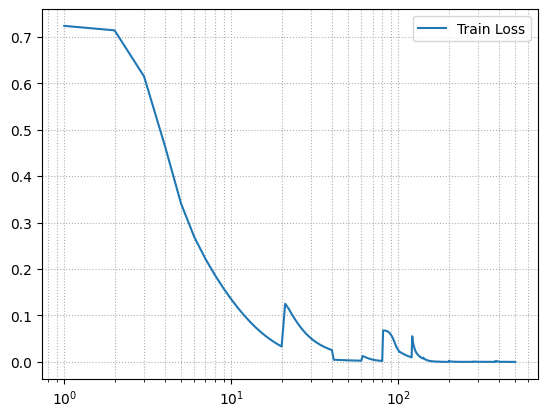

In [7]:
hist = pinn.fit(num_epochs=5, verbose=True)

plt.figure(dpi=100)
plt.grid(True, which="both", ls=":")
plt.plot(np.arange(1, len(hist) + 1), hist, label="Train Loss")
plt.xscale("log")
plt.legend()

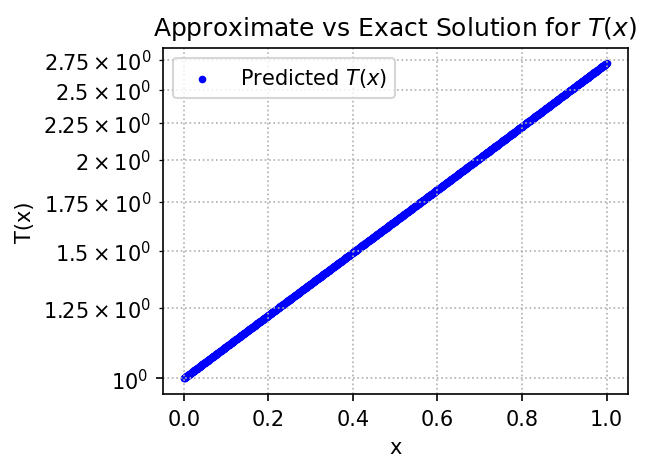

In [8]:
pinn.plotting()